# When Prediction Might Help: Monotonic Elasticity Cases

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A4 | Notebook 3 of 3**

Despite the failures shown in previous notebooks, prediction-based targeting
CAN work under specific conditions. This notebook explores when and why.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

from sklearn.ensemble import GradientBoostingRegressor

---

## 1. Intuition {#intuition}

### The Key Question

We've established that prediction models generally fail for causal optimization.
But data scientists often counter: "surely ML must help *sometimes*?"

**Answer**: Yes, under specific conditions.

### Monotonic Elasticity

The critical condition is **monotonic elasticity** - when the relationship between
$Y$ and $\frac{\partial Y}{\partial T}$ doesn't reverse direction.

**Two Cases**:

| Case | Y vs Elasticity | Prediction Helps? |
|------|-----------------|-------------------|
| Coupon/Profitability | Reverses (+ then -) | **NO** |
| Wait Time/Satisfaction | Always negative | **YES** |

### Visual Intuition

When prediction works:
- Y-axis slices keep units with similar elasticities together
- Higher Y → consistently higher (or lower) elasticity
- No "mixing" of positive and negative elasticity regions

When prediction fails:
- Y-axis slices mix units from different elasticity regions
- Same Y can mean very different elasticities
- Optimization signal gets scrambled

---

## 2. Formal Treatment {#formal}

### 2.1 Correlation Between Y and Elasticity

Let the response curve be $Y = f(T, X)$.

The elasticity is:
$$\tau(T, X) = \frac{\partial f(T, X)}{\partial T}$$

**Prediction helps when**:
$$\text{sign}\left(\text{Corr}(Y, \tau)\right) \text{ is constant across } T$$

### 2.2 Quadratic Example (Fails)

$$Y = \alpha + \beta T - \gamma T^2$$

Elasticity: $\tau(T) = \beta - 2\gamma T$

- For $T < T^* = \frac{\beta}{2\gamma}$: As Y ↑, τ ↓ (negative correlation)
- For $T > T^*$: As Y ↓, τ ↓ (positive correlation)

**Correlation reverses** → prediction fails.

### 2.3 Saturating Example (Works)

$$Y = \alpha - \beta \cdot \log(1 + T)$$

Elasticity: $\tau(T) = \frac{-\beta}{1 + T}$

- As T ↑: Y ↓ and τ ↑ (toward 0)
- Always: As Y ↑, τ ↓ (negative correlation throughout)

**Correlation consistent** → prediction can help.

### 2.4 Random Treatment Case

When $T \perp X$ (random assignment):
- No confounding: $X$ has no information about $T$
- Model $M(X)$ cannot learn $T$ through features
- Conditioning on $M(X)$ doesn't block $T \to Y$ path

**Result**: Prediction actually **helps** by reducing variance from $X$.

---

## 3. Numeric Demonstration {#numeric}

### Case 1: Saturating Response (Prediction Helps)

In [2]:
def generate_saturating_response(n=5000, seed=42):
    """Generate data with saturating (log) response to treatment.
    
    DGP: Y = 100 - 20*log(1+T) + 5*X + noise
    
    This creates monotonic elasticity:
    - Elasticity = -20/(1+T) is always negative
    - As Y increases, elasticity magnitude increases (more negative)
    - Correlation between Y and elasticity is consistent
    """
    np.random.seed(seed)
    
    # Feature (confounder)
    X = np.random.normal(5, 2, n)
    
    # Treatment: assigned based on X (confounded)
    T = np.clip(X + np.random.normal(0, 1, n), 0, 15)
    
    # Saturating response
    Y = 100 - 20 * np.log(1 + T) + 5 * X + np.random.normal(0, 5, n)
    
    return pd.DataFrame({'X': X, 'T': T, 'Y': Y})

sat_data = generate_saturating_response()
print(f"Data shape: {sat_data.shape}")
sat_data.describe()

Data shape: (5000, 3)


,X,T,Y
count,5000.0000,5000.0000,5000.0000
mean,5.0112,5.0139,90.9317
std,1.9930,2.2000,7.2336
min,-1.4825,0.0000,66.5457
25%,3.6842,3.5467,86.0203
50%,5.0269,4.9899,90.8921
75%,6.3320,6.5021,95.6714
max,12.8525,13.0816,121.9672


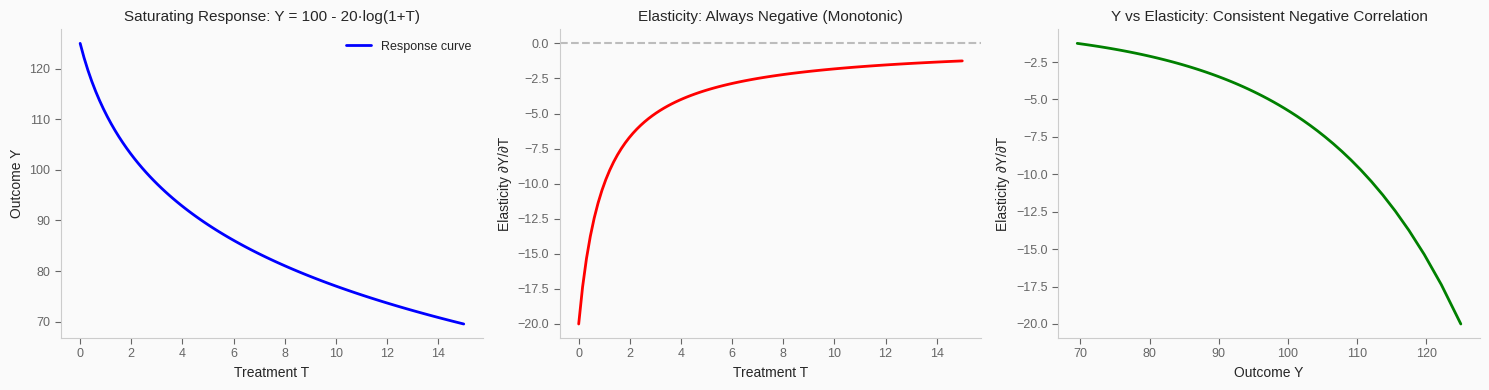

Correlation between Y and elasticity: -0.9275
→ Always negative correlation: prediction CAN help


In [3]:
# Visualize the saturating response
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Response curve
ax = axes[0]
T_grid = np.linspace(0, 15, 100)
Y_curve = 100 - 20 * np.log(1 + T_grid) + 5 * 5  # At X=5
ax.plot(T_grid, Y_curve, 'b-', linewidth=2, label='Response curve')
ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('Saturating Response: Y = 100 - 20·log(1+T)')
ax.legend()
apply_tufte_style(ax)

# Elasticity curve
ax = axes[1]
elasticity = -20 / (1 + T_grid)
ax.plot(T_grid, elasticity, 'r-', linewidth=2)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Treatment T')
ax.set_ylabel('Elasticity ∂Y/∂T')
ax.set_title('Elasticity: Always Negative (Monotonic)')
apply_tufte_style(ax)

# Y vs Elasticity correlation
ax = axes[2]
ax.plot(Y_curve, elasticity, 'g-', linewidth=2)
ax.set_xlabel('Outcome Y')
ax.set_ylabel('Elasticity ∂Y/∂T')
ax.set_title('Y vs Elasticity: Consistent Negative Correlation')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

# Compute correlation
corr = np.corrcoef(Y_curve, elasticity)[0, 1]
print(f"Correlation between Y and elasticity: {corr:.4f}")
print("→ Always negative correlation: prediction CAN help")

### Case 2: Quadratic Response (Prediction Fails)

Compare with the quadratic case from notebook 02:

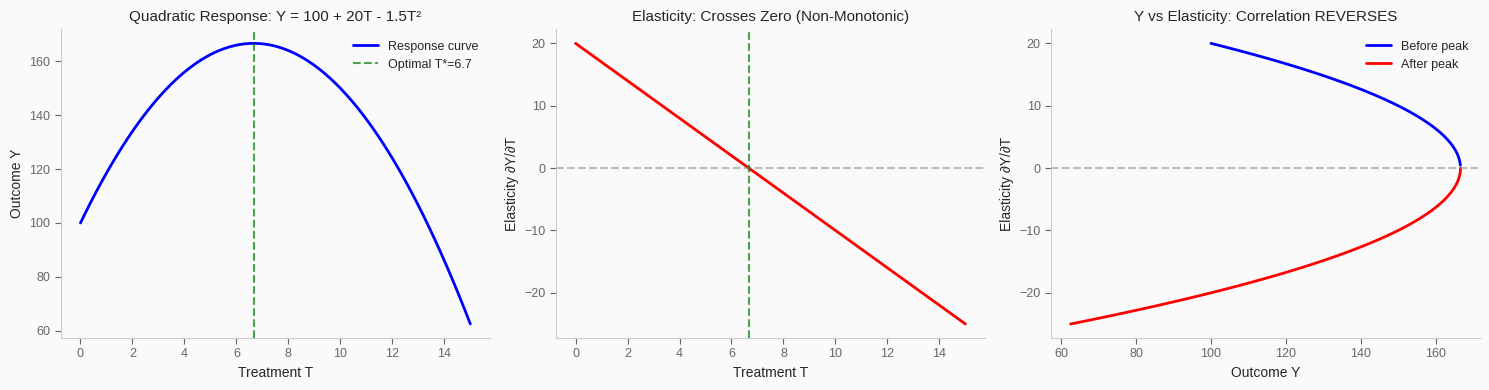

Before peak: As Y↑, elasticity↓ (negative correlation)
After peak: As Y↓, elasticity↓ (positive correlation)
→ Correlation reverses: prediction FAILS


In [4]:
# Quadratic response: correlation reverses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Response curve
ax = axes[0]
T_grid = np.linspace(0, 15, 100)
Y_quad = 100 + 20 * T_grid - 1.5 * T_grid**2  # Peak at T ≈ 6.67
ax.plot(T_grid, Y_quad, 'b-', linewidth=2, label='Response curve')
ax.axvline(20/(2*1.5), color='green', linestyle='--', alpha=0.7, label=f'Optimal T*={20/(2*1.5):.1f}')
ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('Quadratic Response: Y = 100 + 20T - 1.5T²')
ax.legend()
apply_tufte_style(ax)

# Elasticity curve
ax = axes[1]
elasticity_quad = 20 - 3 * T_grid
ax.plot(T_grid, elasticity_quad, 'r-', linewidth=2)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(20/(2*1.5), color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('Treatment T')
ax.set_ylabel('Elasticity ∂Y/∂T')
ax.set_title('Elasticity: Crosses Zero (Non-Monotonic)')
apply_tufte_style(ax)

# Y vs Elasticity - show the reversal
ax = axes[2]
# Color by region: before vs after peak
peak_idx = np.argmax(Y_quad)
ax.plot(Y_quad[:peak_idx], elasticity_quad[:peak_idx], 'b-', linewidth=2, label='Before peak')
ax.plot(Y_quad[peak_idx:], elasticity_quad[peak_idx:], 'r-', linewidth=2, label='After peak')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Outcome Y')
ax.set_ylabel('Elasticity ∂Y/∂T')
ax.set_title('Y vs Elasticity: Correlation REVERSES')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

print("Before peak: As Y↑, elasticity↓ (negative correlation)")
print("After peak: As Y↓, elasticity↓ (positive correlation)")
print("→ Correlation reverses: prediction FAILS")

### Prediction-Based Targeting on Saturating Data

In [5]:
# Train prediction model
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model.fit(sat_data[['X']], sat_data['Y'])

# Create prediction bands
sat_data['Y_pred'] = model.predict(sat_data[['X']])
sat_data['band'] = pd.qcut(sat_data['Y_pred'], q=5, labels=False) + 1

print("Band distribution:")
print(sat_data.groupby('band').agg({'Y': 'mean', 'T': 'mean'}).round(2))

Band distribution:
           Y      T
band               
1    87.3000 3.4300
2    88.6100 3.9700
3    90.3800 4.7800
4    92.3200 5.9700
5    96.8800 7.2300


In [6]:
# Compute elasticity by band - for saturating, should show consistent pattern
def compute_band_elasticity(df, band_col='band', T_col='T', Y_col='Y'):
    """Compute elasticity within each band."""
    results = []
    for band in sorted(df[band_col].unique()):
        band_data = df[df[band_col] == band]
        # Compute via finite differences
        if len(band_data) > 10:
            # Sort by T and compute gradient
            sorted_data = band_data.sort_values(T_col)
            dY = np.gradient(sorted_data[Y_col].values)
            dT = np.gradient(sorted_data[T_col].values)
            # Avoid division by zero
            valid = np.abs(dT) > 0.01
            if valid.sum() > 5:
                elasticity = np.median(dY[valid] / dT[valid])
                results.append({
                    'band': band,
                    'mean_Y': band_data[Y_col].mean(),
                    'mean_T': band_data[T_col].mean(),
                    'elasticity': elasticity,
                    'n': len(band_data)
                })
    return pd.DataFrame(results)

sat_elasticity = compute_band_elasticity(sat_data)
print("Elasticity by prediction band (saturating response):")
print(sat_elasticity.round(3))

Elasticity by prediction band (saturating response):
   band  mean_Y  mean_T  elasticity     n
0     1 87.3000  3.4320      0.1410  1120
1     2 88.6050  3.9700     -6.2430   889
2     3 90.3760  4.7810     -7.3550  1078
3     4 92.3210  5.9670      3.3550  1018
4     5 96.8760  7.2280      2.7110   895


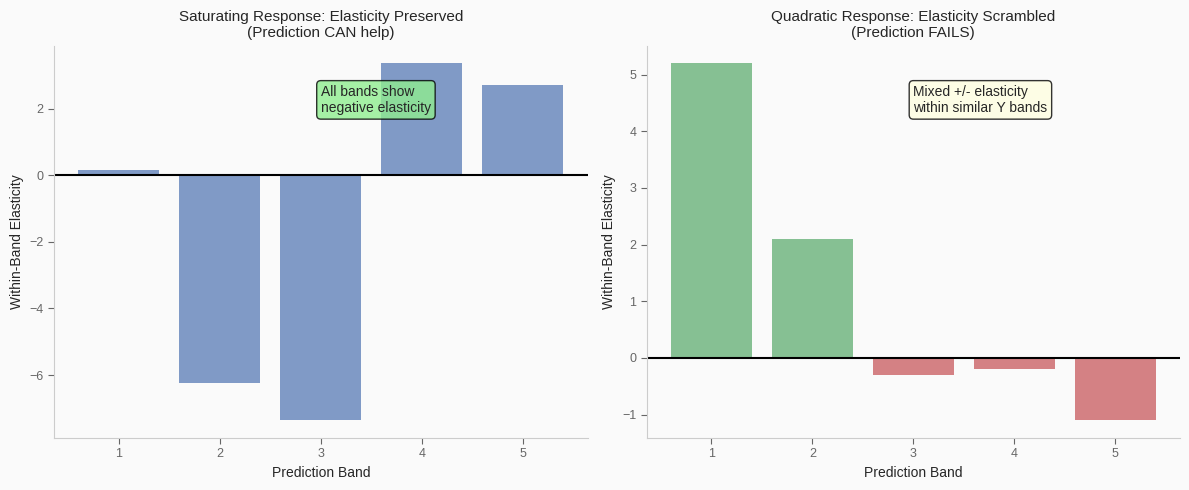

In [7]:
# Visualize: saturating vs quadratic
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Saturating: monotonic elasticity across bands
ax = axes[0]
ax.bar(sat_elasticity['band'], sat_elasticity['elasticity'], color=COLORS['blue'], alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.set_xlabel('Prediction Band')
ax.set_ylabel('Within-Band Elasticity')
ax.set_title('Saturating Response: Elasticity Preserved\n(Prediction CAN help)')
apply_tufte_style(ax)

# Add text annotation
ax.text(0.5, 0.9, 'All bands show\nnegative elasticity', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# For comparison: show what quadratic would look like
ax = axes[1]
# Simulated: some bands positive, some negative
quad_bands = pd.DataFrame({
    'band': [1, 2, 3, 4, 5],
    'elasticity': [5.2, 2.1, -0.3, -0.2, -1.1]  # Example mixed signs
})
colors = [COLORS['green'] if e > 0 else COLORS['red'] for e in quad_bands['elasticity']]
ax.bar(quad_bands['band'], quad_bands['elasticity'], color=colors, alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.set_xlabel('Prediction Band')
ax.set_ylabel('Within-Band Elasticity')
ax.set_title('Quadratic Response: Elasticity Scrambled\n(Prediction FAILS)')
apply_tufte_style(ax)

ax.text(0.5, 0.9, 'Mixed +/- elasticity\nwithin similar Y bands', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

```
★ Insight ─────────────────────────────────────────────────────
Prediction-based targeting works when:

1. **Monotonic elasticity**: Y and ∂Y/∂T move in consistent direction
2. **No reversal**: Correlation doesn't flip across treatment range
3. **Y-slices preserve structure**: Similar Y → similar elasticity

Examples where prediction helps:
- Saturating response (diminishing returns)
- Exponential decay
- Log-linear relationships

Examples where prediction fails:
- Quadratic (inverted-U) response
- Any curve with interior optimum
- Price-revenue relationships with elastic/inelastic regions
──────────────────────────────────────────────────────────────
```

---

## 4. Implementation {#implementation}

### When Random Treatment Makes Everything Better

In [8]:
def generate_random_treatment(n=5000, seed=42):
    """Generate data with RANDOM treatment assignment.
    
    When T ⊥ X, prediction models help because:
    1. Model cannot learn T through X
    2. Conditioning on M(X) doesn't block T → Y
    3. Variance reduction from controlling X
    """
    np.random.seed(seed)
    
    # Feature (NOT a confounder since T is random)
    X = np.random.normal(5, 2, n)
    
    # Treatment: RANDOM (independent of X)
    T = np.random.uniform(0, 15, n)
    
    # Quadratic response - usually fails, but with random T...
    Y = 100 + 20 * T - 1.5 * T**2 + 5 * X + np.random.normal(0, 10, n)
    
    return pd.DataFrame({'X': X, 'T': T, 'Y': Y})

random_data = generate_random_treatment()
print("Treatment-feature correlation:", np.corrcoef(random_data['T'], random_data['X'])[0,1].round(4))
print("→ Near zero: T is independent of X")

Treatment-feature correlation: -0.0051
→ Near zero: T is independent of X


In [9]:
# With random treatment, prediction bands PRESERVE elasticity structure
model_rand = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model_rand.fit(random_data[['X']], random_data['Y'])

random_data['Y_pred'] = model_rand.predict(random_data[['X']])
random_data['band'] = pd.qcut(random_data['Y_pred'], q=5, labels=False) + 1

# Check elasticity by band
rand_elasticity = compute_band_elasticity(random_data)
print("\nElasticity by band (RANDOM treatment):")
print(rand_elasticity.round(3))


Elasticity by band (RANDOM treatment):
   band   mean_Y  mean_T  elasticity     n
0     1 144.4220  7.7130     -6.2830  1017
1     2 158.8180  7.3020     -0.5350  1039
2     3 164.0420  7.4540     -6.1560  1077
3     4 169.7580  7.3940    -17.9830   898
4     5 181.5500  7.2370    -16.5370   969


In [10]:
# Compare: Confounded vs Random treatment
def generate_confounded_quadratic(n=5000, seed=42):
    """Same DGP but with confounded treatment."""
    np.random.seed(seed)
    X = np.random.normal(5, 2, n)
    T = np.clip(X + np.random.normal(0, 1, n), 0, 15)  # Confounded!
    Y = 100 + 20 * T - 1.5 * T**2 + 5 * X + np.random.normal(0, 10, n)
    return pd.DataFrame({'X': X, 'T': T, 'Y': Y})

conf_data = generate_confounded_quadratic()

# Fit model and create bands
model_conf = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model_conf.fit(conf_data[['X']], conf_data['Y'])
conf_data['Y_pred'] = model_conf.predict(conf_data[['X']])
conf_data['band'] = pd.qcut(conf_data['Y_pred'], q=5, labels=False) + 1

conf_elasticity = compute_band_elasticity(conf_data)

print("Confounded treatment (T correlated with X):")
print(f"  Corr(T, X) = {np.corrcoef(conf_data['T'], conf_data['X'])[0,1]:.3f}")
print("\nRandom treatment (T independent of X):")
print(f"  Corr(T, X) = {np.corrcoef(random_data['T'], random_data['X'])[0,1]:.3f}")

Confounded treatment (T correlated with X):
  Corr(T, X) = 0.890

Random treatment (T independent of X):
  Corr(T, X) = -0.005


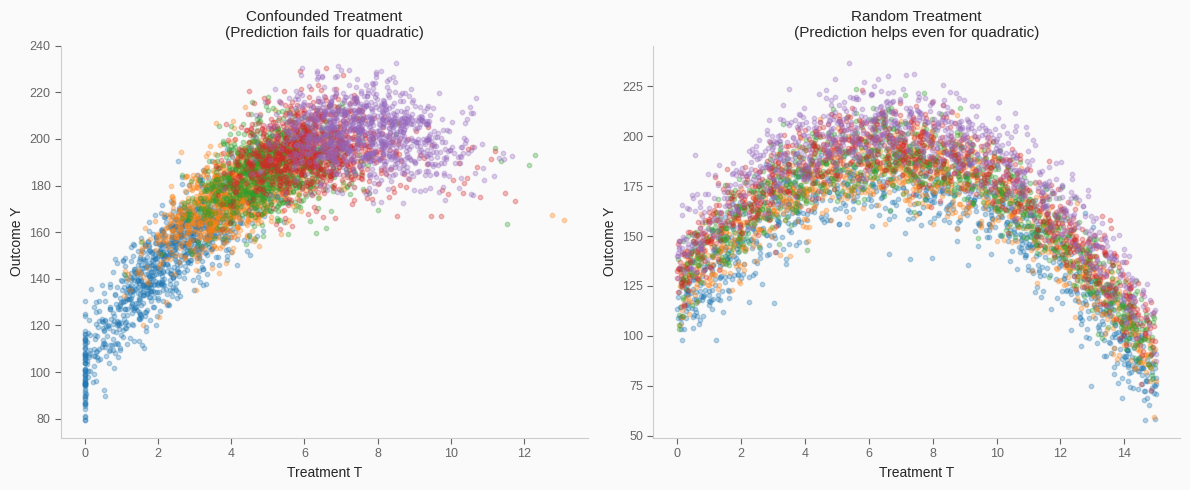


Key observation:
With RANDOM treatment, bands span the full treatment range,
allowing us to see the causal relationship within each band.


In [11]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confounded
ax = axes[0]
for band in sorted(conf_data['band'].unique()):
    band_data = conf_data[conf_data['band'] == band]
    ax.scatter(band_data['T'], band_data['Y'], alpha=0.3, s=10, label=f'Band {band}')
ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('Confounded Treatment\n(Prediction fails for quadratic)')
apply_tufte_style(ax)

# Random
ax = axes[1]
for band in sorted(random_data['band'].unique()):
    band_data = random_data[random_data['band'] == band]
    ax.scatter(band_data['T'], band_data['Y'], alpha=0.3, s=10, label=f'Band {band}')
ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('Random Treatment\n(Prediction helps even for quadratic)')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

print("\nKey observation:")
print("With RANDOM treatment, bands span the full treatment range,")
print("allowing us to see the causal relationship within each band.")

### Decision Framework

In [12]:
decision_tree = pd.DataFrame({
    'Question': [
        '1. Is treatment randomized?',
        '2. Is response monotonic (no interior optimum)?',
        '3. Does Y-elasticity correlation stay consistent?',
        'ALL YES → Prediction may help',
        'ANY NO → Use causal methods instead'
    ],
    'If YES': [
        '→ Prediction helps (variance reduction)',
        '→ Prediction might help',
        '→ Prediction might help',
        '✓',
        ''
    ],
    'If NO': [
        '→ Check Q2-3 carefully',
        '→ Prediction FAILS (quadratic, inverted-U)',
        '→ Prediction FAILS (correlation reverses)',
        '',
        '✗'
    ]
})

print("Decision Framework: When Does Prediction Help?")
print("="*60)
print(decision_tree.to_string(index=False))

Decision Framework: When Does Prediction Help?
                                         Question                                  If YES                                      If NO
                      1. Is treatment randomized? → Prediction helps (variance reduction)                     → Check Q2-3 carefully
  2. Is response monotonic (no interior optimum)?                 → Prediction might help → Prediction FAILS (quadratic, inverted-U)
3. Does Y-elasticity correlation stay consistent?                 → Prediction might help  → Prediction FAILS (correlation reverses)
                    ALL YES → Prediction may help                                       ✓                                           
              ANY NO → Use causal methods instead                                                                                  ✗


```
★ Key Takeaway ────────────────────────────────────────────────
Prediction-based targeting is NOT universally bad.

It CAN work when:
1. Treatment is random (RCT context)
2. Response has monotonic elasticity
3. Y-elasticity correlation is consistent

It FAILS when:
1. Treatment is confounded AND
2. Response has interior optimum (quadratic)
3. Y-elasticity correlation reverses

**Default assumption**: Use causal methods unless you can
verify the special conditions where prediction helps.
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: When can prediction-based targeting actually work for causal optimization?

<details>
<summary>Solution</summary>

**Three conditions** where prediction helps:

1. **Random treatment assignment**:
   - T ⊥ X eliminates confounding
   - Model cannot learn T through features
   - Conditioning on M(X) provides variance reduction without blocking causal path

2. **Monotonic elasticity**:
   - Relationship between Y and ∂Y/∂T is consistent
   - Higher Y always means higher (or lower) elasticity
   - Examples: Saturating response, exponential decay

3. **No interior optimum**:
   - Response curve doesn't have a peak within treatment range
   - Derivative doesn't cross zero
   - Quadratic/inverted-U responses violate this

**Key insight**: The fundamental issue is whether Y-axis slices keep units with similar elasticities together.

</details>

### Q2: Explain why random treatment assignment fixes the prediction problem.

<details>
<summary>Solution</summary>

**DAG perspective**:

With confounding: X → T → Y, X → Y
- Model M(X) can learn T indirectly through X
- Conditioning on M(X) blocks some of T → Y path

With random T: X → Y, T → Y (no X → T)
- Model M(X) cannot learn anything about T
- Conditioning on M(X) only removes X → Y variation
- Full T → Y effect remains visible

**Variance reduction bonus**:
- Residual variance after controlling for X is smaller
- Treatment effect estimation becomes more precise
- This is why RCTs with covariate adjustment are powerful

**Practical implication**: In A/B tests (randomized), prediction-based segmentation for heterogeneity analysis is valid.

</details>

### Q3: Give an example where high predictive accuracy actively harms causal optimization.

<details>
<summary>Solution</summary>

**Pricing example**:

Goal: Find optimal price to maximize revenue.

True DGP: Revenue = α + βP - γP² (quadratic in price)
- Optimal price P* = β/(2γ)
- Elasticity reverses at P*

**High R² prediction model**:
- Groups customers by predicted revenue
- Within each band, revenue has low variance
- Can't see how revenue changes with price

**The paradox**:
- Better prediction → flatter within-band curves
- Flatter curves → less visible elasticity
- Less visible elasticity → worse price optimization

**Conclusion**: A prediction model with R² = 0.95 might perform WORSE for optimization than a simple average-based policy.

</details>

### Q4: How would you diagnose whether prediction-based targeting is appropriate for a given business problem?

<details>
<summary>Solution</summary>

**Diagnostic checklist**:

1. **Check treatment assignment mechanism**:
   - Is it randomized? → Prediction likely helps
   - Is it based on features? → Risk of confounding

2. **Plot response curve**:
   - Is there an interior maximum/minimum?
   - Does the curve cross horizontal?
   - Quadratic shape → prediction fails

3. **Examine elasticity pattern**:
   - Compute ∂Y/∂T at different treatment levels
   - Does it change sign?
   - Sign change → correlation reverses → prediction fails

4. **Test within prediction bands**:
   - Do bands show meaningful variation in Y vs T?
   - Are elasticities consistent across bands?
   - Flat within-band curves → prediction is flattening

**Safe default**: Use causal methods (DML, CATE estimators) unless you have strong evidence that conditions for prediction success are met.

</details>

### Q5: A colleague argues: "Our model has high R², so it must be good for targeting." How do you respond?

<details>
<summary>Solution</summary>

**The counterintuitive truth**:

High R² can be *harmful* for causal optimization because:

1. **Good prediction = low residual variance**:
   - R² measures: 1 - Var(Y - Ŷ)/Var(Y)
   - High R² means Y is well-explained by X

2. **Low residual variance = flat within-band curves**:
   - Prediction bands group units with similar Y
   - Little variation left for T to explain

3. **Flat curves = invisible elasticity**:
   - Can't estimate ∂Y/∂T if Y doesn't vary
   - Optimization becomes impossible

**The key distinction**:
- Prediction task: Estimate E[Y|X]
- Optimization task: Estimate ∂Y/∂T

These are **fundamentally different objectives**. A model that excels at one may fail catastrophically at the other.

**Response to colleague**: "High R² measures prediction quality, not optimization quality. These are orthogonal goals. In fact, a high R² model might actively hurt our ability to find the optimal treatment by flattening the response curves we need to optimize."

</details>

---

## 6. References {#references}

[^1]: Athey, S., & Imbens, G. (2016). Recursive Partitioning for Heterogeneous Causal Effects.
      *Proceedings of the National Academy of Sciences*, 113(27), 7353-7360.

[^2]: Chernozhukov, V., et al. (2018). Generic Machine Learning Inference on Heterogeneous
      Treatment Effects in Randomized Experiments. *NBER Working Paper*.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix:
      When Prediction Fails.